# Script to explore radar picks

## Import packages

In [270]:
import geopandas as gpd
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import numpy as np
import pandas as pd


## set basic parameters

In [271]:

# define cores

class core:
    def __init__(self, name, lat, lon, depth):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.depth = depth

    def get_dist_to_track(self,lat,lon):

        self.track_dist=10000
        for i in range(len(lat)):
            d = haversine((lat[i],lon[i]),(self.lat,self.lon),unit=Unit.METERS)
            if d < self.track_dist:
                self.track_dist = d
                self.track_idx = i

ALHIC2302 = core('ALHIC2302',-76.74543,159.37513, 143)
ALHIC2201 = core('ALHIC2201',-76.732027,159.359551, 90)
ALHIC1902 = core('ALHIC1902',-76.745357,159.374108, 206.53)
ALHIC1901 = core('ALHIC1901',-76.732376,159.356125, 159.84)


## Calculate true dip

In [284]:
# define function for weighted_percentile
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-true-angles'])
        scores = np.array(row[ACorDC+'-true-scores'])
        
        # plot dip
        a = weighted_percentile(dip, scores, percentiles)
       # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
        dip_stats.append(a)

        # check
        for i in range(len(a)-1):
            if a[i]>a[i+1]:
                print('Error: Percentiles are not in order in section '+row['section'])

    df['dip_percentiles']  = dip_stats
    return df

In [ ]:
#deine percentiles
percentiles = [10,25,50,75,90]

# Load data
alhic2302_angle = pd.read_pickle('../../data/angles/alhic2302_angles.df')
alhic2201_angle = pd.read_pickle('../../data/angles/alhic2201_angles.df')

# calculate true dip percentiles for alhic2201 and alhic2302
alhic2201_angle = calc_percentiles(alhic2201_angle,percentiles)
alhic2302_angle = calc_percentiles(alhic2302_angle,percentiles)

## Basic data import and exploration

In [272]:
# Function to load the shapefile and check basic information
def load_shapefile(file_path):
    try:
        # Load the shapefile using geopandas
        gdf = gpd.read_file(file_path)
        
        # Display basic information about the data
        print("Loaded shapefile successfully!")
        print("Number of features:", len(gdf))
        print("CRS (Coordinate Reference System):", gdf.crs)
        print("First few rows of the data:")
        print(gdf.head())
        
        # Show the columns in the shapefile
        print("\nColumns in the shapefile:")
        print(gdf.columns)

        # You can access the geometry (the spatial component) and attributes here
        print("\nSample geometry:")
        print(gdf.geometry.head())

    except Exception as e:
        print(f"Error loading shapefile: {e}")

    return gdf

# Provide the path to the .shp file
#shapefile_path = "../../../radar_picks/picks-v2-culled-2melev.shp"
shapefile_path = "../../../radar_picks/picks-v2-culled.shp"
gdf = load_shapefile(shapefile_path)


Loaded shapefile successfully!
Number of features: 26422
CRS (Coordinate Reference System): EPSG:3031
First few rows of the data:
  Filename  St. Scan  End Scan      Lat()      Long() Layer 1 Na  Layer 1 Sc  \
0     None         0      6008 -76.733516  159.345061    Layer 1        1640   
1     None         0      6008 -76.733500  159.345184    Layer 1        1650   
2     None         0      6008 -76.733482  159.345314    Layer 1        1660   
3     None         0      6008 -76.733463  159.345453    Layer 1        1670   
4     None         0      6008 -76.733446  159.345595    Layer 1        1680   

   Layer 1 De  Layer 1 2-  Layer 1 La Layer 2 Na  Layer 2 Sc Layer 2 2-  \
0     296.246     3485.24        3.11    Layer 2        1640       None   
1     293.899     3457.63        3.11    Layer 2        1650       None   
2     290.823     3421.45        3.11    Layer 2        1660       None   
3     288.557     3394.79        3.11    Layer 2        1670       None   
4     285.805 

<Axes: >

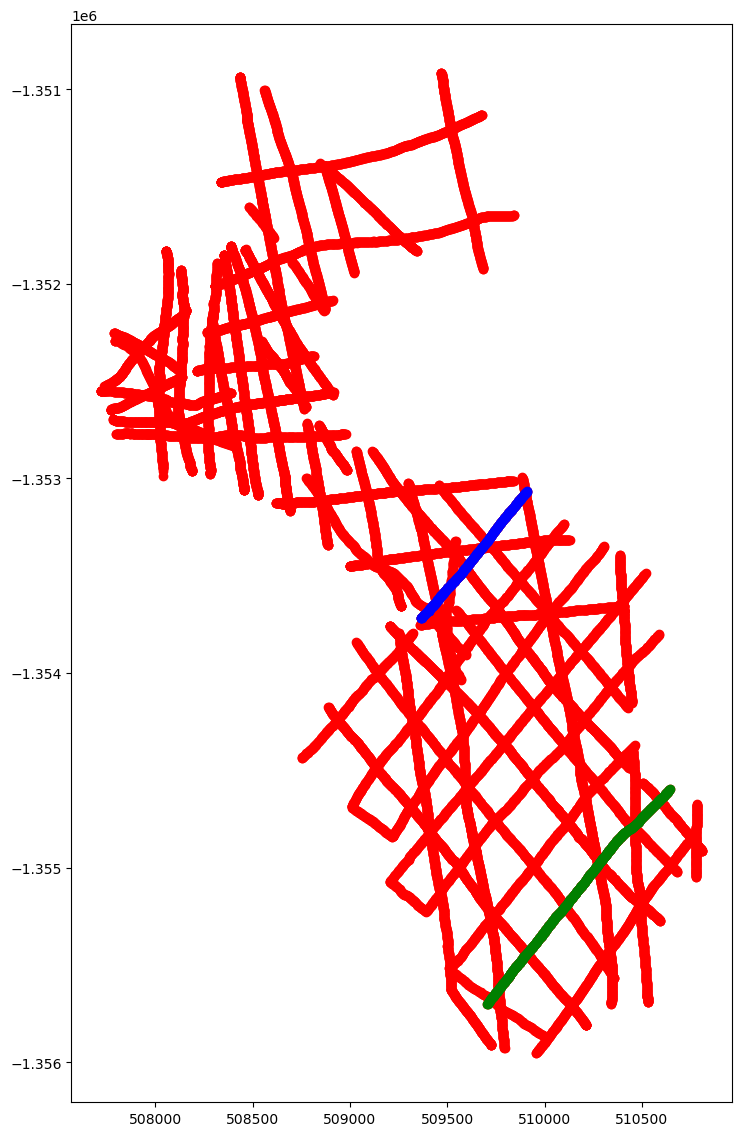

In [273]:
# tool to find the correct lines

fig,ax = plt.subplots(figsize=(14,14))

gdf.plot(ax = ax, color='r')

lo = 1510 # this is right
hi = 1750 # this is right
line23 = gdf[lo:hi]
line23.plot(ax=ax, color='b')

lo = 0 # this is right
hi = 437 # this is right
line02 = gdf[lo:hi]
line02.plot(ax=ax, color='g')



KeyError: 'dip_percentiles'

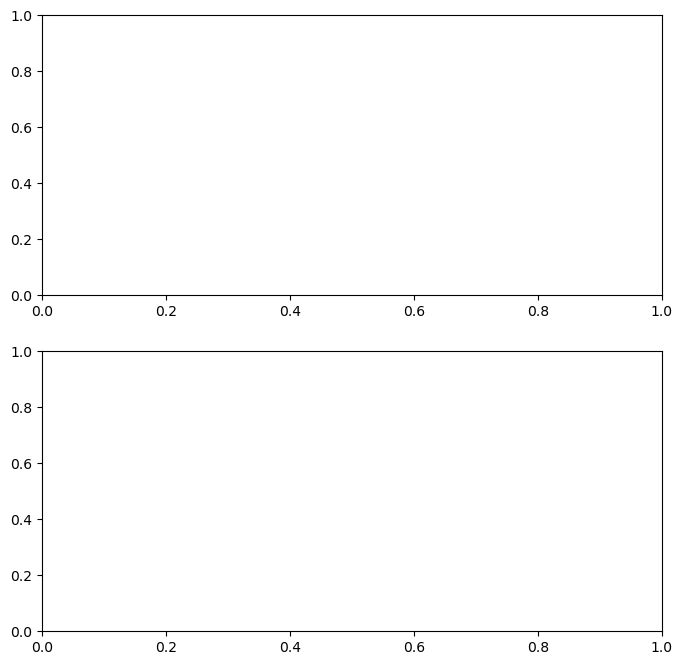

In [281]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

for line,name,ax,cores in zip([line23,line02],['Track 23','Track 2'],[ax[0],ax[1]],[[ALHIC2302,ALHIC1902],[ALHIC2201,ALHIC1901]]):

    # Load radar angle data
    core = cores[0]
    angle_df = pd.read_pickle('../../data/angles/'+core.name+'_angles.df')
    for idx,row in angle_df.iterrows():
        percentiles = row['dip_percentiles'].to_numpy()
        median = percentiles[2]

        print(median)


    # Get the latitude, longitude, and depth values
    lat = line['Lat()'].to_numpy()
    lon = line['Long()'].to_numpy()
    depth = line['Layer 1 De'].to_numpy()

    # find closest point on line
    for core in cores:
        core.get_dist_to_track(lat,lon)
        print(" Distance between "+core.name+" and line is ",core.track_dist)

    # compute distance along track
    dist = []
    for la,lo in zip(lat,lon):
        dist.append(haversine((lat[0],lon[0]),(la,lo),unit=Unit.METERS))

    # plot the data
    ax.plot(dist,depth,label='Bed Pick (Nestbit & Brook, 2023)')

    # plot core location
    color = ['r--','k--']
    for core,c in zip(cores,color):
        label = core.name + ' (~'+str(round(core.track_dist))+' m from track)'
        ax.plot([dist[core.track_idx],dist[core.track_idx]],[0,core.depth],c,label=label)

    # calculate the bed slope near the core
    core = cores[0] # pick relevant core
    idx = core.track_idx
    dist_min = dist[idx] - 20
    dist_max = dist[idx] + 20
    idx_min = int(round(np.interp(dist_min,dist,range(len(dist)))))
    idx_max = int(round(np.interp(dist_max,dist,range(len(dist)))))
    slope = abs((depth[idx_max] - depth[idx_min])/(dist[idx_max] - dist[idx_min]))
    dip = np.arctan(slope)*180/np.pi
    print('Bed slope near '+core.name+' is ',slope,' or ',dip,' degrees')

    # plot the bed slope
    ax.plot([dist_min,dist_max],[depth[idx_min],depth[idx_max]],'r',label='Bed Slope under '+core.name+' ('+str(round(dip,1))+' degrees)',linewidth=4)

    # set axis to equal scale
    ax.axis('equal')

    # apply x axis limits
    if name == 'Track 23':
        ax.set_xlim(0,800)
        ax.legend(loc='upper right')
    else:
        ax.set_xlim(0,800)
        ax.legend(loc='lower right')


    # plot housekeeping
    title = name + ' - ' + cores[0].name +'/'+cores[1].name 
    ax.set_title(title)
    ax.set_xlabel('Distance along track (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim(300,0)
    ax.grid(True)

fig.tight_layout()

# get size
#sz = fig.get_size_inches()
#fig.set_size_inches(sz[0]*1.5, sz[1]*1.5)

In [283]:
row

section                                                                   10
depth                                                               8.874906
AC-l-angles                [66.0, -75.0, -63.0, -41.0, -64.0, 66.0, -75.0...
AC-l-scores                [0.6582756816296401, 0.7354147007539482, 0.712...
AC-l-length                [0.41999999999999993, 0.41999999999999993, 0.4...
10-90 percentile spread                                             2.224025
DC-l-angles                [-60.0, -64.0, -16.0, 14.0, -1.0, 73.0, -60.0,...
DC-l-scores                [0.7721727541172921, 0.5939928997475274, 0.369...
DC-l-length                [0.3600000000000012, 0.3600000000000012, 0.360...
AC-t-angles                [75.0, 75.0, -65.0, 57.0, 14.0, 75.0, 16.0, 23...
AC-t-scores                [0.850815802556342, 0.5411354451109035, 0.3206...
AC-t-length                [0.39000000000000057, 0.39000000000000057, 0.3...
DC-t-angles                [-23.0, 2.0, 22.0, 11.0, -23.0, 25.0, 34.0, 8....

In [276]:
core.name

AttributeError: type object 'core' has no attribute 'name'

In [268]:
fig.get_size_inches()

array([8., 8.])